In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [70]:
from catboost import CatBoostRegressor, CatBoostClassifier
from catboost import Pool
from sklearn.model_selection import  train_test_split
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    average_precision_score,
    recall_score,
    matthews_corrcoef,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import shap
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

In [3]:
def score_regression_simple(target, predictions,) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)

    metrics = {
        "R2":       round(r2_score(target, predictions),3),
        "MAE":  round(mean_absolute_error(target, predictions),3),
        "MSE":  round(mean_squared_error(target, predictions),3),
        "RMSE":   round((np.sqrt(mean_squared_error(target, predictions))),3),
        "MAPE":        round(mean_absolute_percentage_error(target, predictions),3),
        } 
    return metrics


def score_classifier_simple(target, predictions, threshold=0.5) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)
    response = (predictions > threshold).astype(int)

    metrics = {
        "roc_auc_score":   round((np.sqrt(roc_auc_score(target, predictions))),3),
        "av_precision_score": round((np.sqrt(average_precision_score(target, predictions))),3),
        "accuracy_score":  round(accuracy_score(target, response),3),
        "precision_score":  round(precision_score(target, response),3),
        "recall_score":   round((np.sqrt(recall_score(target, response))),3),
        "f1_score":       round(f1_score(target, response),3),
        "matthews_corrcoef":        round(matthews_corrcoef(target, response),3),
        } 
    return metrics

# SETUP

In [8]:
BD_NAME = 'export_20220915060001.csv'
BD_FOLDER = './data'
VERSION = 'v2.2.220915'
START_DATE = '2022-08-25'
TETS_DATE = '2022-09-12'

In [9]:
data_quality_expected_range_dict = {
    'sneaker':
        {
        #'is_type': {'genesis': bool},
        'is_in':
            {
            'rarity': ['common', 'uncommon', 'rare'],
            'sneaker_type': ['ranger', 'sprinter', 'hiker', 'coacher'],
            },
        'min_max':
            {
            'level': [0, 30],
            'base_performance': [0, 40],
            'base_fortune': [0, 40],
            'base_joy': [0, 40],
            'base_durability': [0, 40],
            'performance': [0, 500],
            'fortune': [0, 300],
            'joy': [0, 300],
            'durability': [0, 300],
            'mint': [0, 7],
            'buy_count_12H': [0, 500],
            'buy_count_24H': [0, 1000],
            'sell_count_24H': [0, 2000],
            'cancel_count_24H': [0, 1000],
            'token_all_activity_3H': [0, 30],
            'token_sell_activity_6H': [0, 30],
            },
        }
}

# DATA

In [10]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb,predict_base,predict
0,1663221584,30204,21351,sell,0xbcb6d8ad08ad6cd98fd7af1450c0a2317910a3dd,NaN,1.00,sneakers,common,ranger,...,516559.0,5.0,4.0,900.0,1800.0,300.0,200.0,0.6694,0.980,0.987
1,1663221584,30185,49404,buy,0x175f138dbf3579746fb11ed4af6da9d34a772315,0x89aad2baedbe394a1a1834342810ab8adb3ff7f4,0.80,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1663221455,30167,46932,cancel,0x384d2b71a053d359b1a473061c73e0176267b8ca,NaN,NaN,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1663221488,30203,29778,sell,0x9c7ba187dce7510c5c11ac1dc7d98691e584d927,NaN,1.00,sneakers,common,hiker,...,514078.0,5.0,5.0,900.0,1800.0,300.0,200.0,0.6694,0.997,0.993
4,1663221452,30098,38618,buy,0x916137b9481ed04343cc36e76220aaa549757586,0xc8e758392e660a60519cd6ee9eab3b3daffd9815,0.78,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32259,1661029606,13798,24335,sell,0x0d4eafe1ed97f590fde02c21dcf2b0ae6cb106d7,NaN,0.90,sneakers,common,hiker,...,108.0,7.0,9.0,900.0,1800.0,300.0,200.0,NaN,NaN,NaN
32260,1661029594,13797,27211,sell,0xb83b40609684191abba9184f627a112df5ac0a44,NaN,0.92,sneakers,common,hiker,...,309.0,5.0,5.0,900.0,1800.0,300.0,200.0,NaN,NaN,NaN
32261,1661029585,13596,32513,buy,0x1041f11e1738c5ea8d3ff3c5a1a314a617313ee1,0x2eeedd73169a17e4f79a6d6bea238f11b05238e4,0.92,box,common,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32262,1661029462,13796,32779,sell,0x668ff3191878ed0f7112031305eccb1d79a865e4,NaN,1.00,sneakers,common,sprinter,...,216.0,7.0,8.0,0.0,1800.0,300.0,200.0,NaN,NaN,NaN


In [11]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [12]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32264 entries, 0 to 32263
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  16415 non-null  float64
 1   time_ownership             16415 non-null  float64
 2   wallet_box_mint            14440 non-null  float64
 3   wallet_sneaker_mint        14441 non-null  float64
 4   time_level_up              14934 non-null  float64
 5   time_level_up_for_mint     14934 non-null  float64
 6   base_mint_price_amt        14934 non-null  float64
 7   base_mint_price_azy        14934 non-null  float64
 8   base_mint_price_bnb        8339 non-null   float64
dtypes: float64(9)
memory usage: 2.2 MB


In [13]:
data.genesis

0         True
1        False
2        False
3         True
4        False
         ...  
32259     True
32260    False
32261    False
32262    False
32263     True
Name: genesis, Length: 32264, dtype: bool

In [14]:
data = data[(data.item_type == 'sneakers') & (data.event == 'buy')].copy()
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb,predict_base,predict
1,1663221584,30185,49404,buy,0x175f138dbf3579746fb11ed4af6da9d34a772315,0x89aad2baedbe394a1a1834342810ab8adb3ff7f4,0.80,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1663221452,30098,38618,buy,0x916137b9481ed04343cc36e76220aaa549757586,0xc8e758392e660a60519cd6ee9eab3b3daffd9815,0.78,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1663221227,30172,34887,buy,0x91b31c5e9453aaad8a19fcc06382b8bb9788399a,0xec5ff07c939d7b1ea46c1f49839e7dacb00fedce,0.78,sneakers,common,sprinter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1663221173,30201,40421,buy,0xcfb8d08480391ff59d5007c3cdba266c1635c77c,0xec5ff07c939d7b1ea46c1f49839e7dacb00fedce,0.76,sneakers,common,sprinter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1663221137,30149,36901,buy,0xdcfc8305898b32e29a9fd63f8f92a9180cebae3c,0x961dcbed2ce5c6ce42d947b2e70966eb2527d194,0.78,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32201,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32224,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32238,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32243,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# data_quality

In [15]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    for element in data[feature].unique():
        if element not in dq[feature]:
            print(f'{feature} not in data_quality_expected_range_dict. get {element}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    if data[feature].min() < dq[feature][0]:
        print(f'{feature} less then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

    if data[feature].max() > dq[feature][1]:
        print(f'{feature} more then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

In [16]:
data['mint'].isna().sum()

0

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6159 entries, 1 to 32257
Data columns (total 59 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        6159 non-null   int64  
 1   mrk_id                                           6159 non-null   int64  
 2   token_id                                         6159 non-null   int64  
 3   event                                            6159 non-null   object 
 4   wallet_from                                      6159 non-null   object 
 5   wallet_to                                        6159 non-null   object 
 6   price                                            6159 non-null   float64
 7   item_type                                        6159 non-null   object 
 8   rarity                                           6159 non-null   object 
 9   sneaker_type                 

In [18]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6159 entries, 1 to 32257
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  0 non-null      float64
 1   time_ownership             0 non-null      float64
 2   wallet_box_mint            0 non-null      float64
 3   wallet_sneaker_mint        0 non-null      float64
 4   time_level_up              0 non-null      float64
 5   time_level_up_for_mint     0 non-null      float64
 6   base_mint_price_amt        0 non-null      float64
 7   base_mint_price_azy        0 non-null      float64
 8   base_mint_price_bnb        0 non-null      float64
dtypes: float64(9)
memory usage: 481.2 KB


In [19]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']]

,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
32201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [21]:
#int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint']
#float_columns = ['performance', 'fortune', 'joy', 'durability', 'price']
#cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [22]:
#for columns in int_columns:
#    data[columns] = data[columns].astype('int')

# for columns in float_columns:
#     data[columns] = data[columns].astype('float')

#for columns in cat_columns:
#    data[columns] = data[columns].astype('category')

In [23]:
#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6159 entries, 1 to 32257
Data columns (total 59 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        6159 non-null   int64  
 1   mrk_id                                           6159 non-null   int64  
 2   token_id                                         6159 non-null   int64  
 3   event                                            6159 non-null   object 
 4   wallet_from                                      6159 non-null   object 
 5   wallet_to                                        6159 non-null   object 
 6   price                                            6159 non-null   float64
 7   item_type                                        6159 non-null   object 
 8   rarity                                           6159 non-null   object 
 9   sneaker_type                 

In [25]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb,predict_base,predict
1,1663221584,30185,49404,buy,0x175f138dbf3579746fb11ed4af6da9d34a772315,0x89aad2baedbe394a1a1834342810ab8adb3ff7f4,0.80,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1663221452,30098,38618,buy,0x916137b9481ed04343cc36e76220aaa549757586,0xc8e758392e660a60519cd6ee9eab3b3daffd9815,0.78,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1663221227,30172,34887,buy,0x91b31c5e9453aaad8a19fcc06382b8bb9788399a,0xec5ff07c939d7b1ea46c1f49839e7dacb00fedce,0.78,sneakers,common,sprinter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1663221173,30201,40421,buy,0xcfb8d08480391ff59d5007c3cdba266c1635c77c,0xec5ff07c939d7b1ea46c1f49839e7dacb00fedce,0.76,sneakers,common,sprinter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1663221137,30149,36901,buy,0xdcfc8305898b32e29a9fd63f8f92a9180cebae3c,0x961dcbed2ce5c6ce42d947b2e70966eb2527d194,0.78,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32201,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32224,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32238,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32243,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

In [27]:
data[data.duplicated(['token_id', 'item_type', 'rarity', 'sneaker_type', 'level', 'mint',])]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb,predict_base,predict,date
31768,1661076949,14027,23846,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0x7bdf18948f2b640ba7fea97875849038bd43da2c,0.73,sneakers,common,sprinter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-21 10:15:49
31717,1661079343,14070,20408,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0x7dd69ca014565e2c9e1b47beabf57a4469d51fe1,0.73,sneakers,common,sprinter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-21 10:55:43
31514,1661087557,14094,26385,buy,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,0x06333746416b07371d84d1f862a352ec7ca1ab10,1.16,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-21 13:12:37
31319,1661095945,14208,16352,buy,0xec04f1a68a3618028f3431ccf570508d95d34dce,0x3ae4020278e724bec4d24135bf9d42b6879a648f,0.69,sneakers,common,sprinter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-21 15:32:25
30588,1661155769,14662,31425,buy,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0xf1a560df54f04b45e756d1cb36241fec633134a2,0.70,sneakers,common,sprinter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-22 08:09:29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,1663207946,30052,40908,buy,0x022ccdfc16c1acb84131d1324ca6daad478381ee,0xf1789c41cac4986cd789db4c9863ed3d225ca746,0.78,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-15 02:12:26
111,1663209878,30048,42447,buy,0x022ccdfc16c1acb84131d1324ca6daad478381ee,0x0b8bc53f79ee6aeb0eadac68b9c3a6cea767bb6d,0.78,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-15 02:44:38
61,1663216805,30105,32616,buy,0x5f3d4e90403821706d5bf37f0b75bddc87f4ed68,0x155cbc75cf4d56d477104149f3901846cbd5f1b5,0.78,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-15 04:40:05
45,1663218473,29969,42752,buy,0x3dd2309e96dd52d47b11b55f79a41990428c4a61,0xf191581b3e5c7e2bd4fbfb838604b28b38264024,0.78,sneakers,common,sprinter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-15 05:07:53


In [28]:
#len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

In [29]:
#train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()

# ML

## FE

In [30]:
#data['min_price_by_rarity_genesis_type_level_mint_24H_nan'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].isna()
#data['min_price_by_rarity_genesis_type_24H_nan'] = data['min_price_by_rarity_genesis_type_24H'].isna()

#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']

In [31]:
data['token_sell_activity_6H'].max()

11

In [32]:
data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(np.nan)
data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(np.nan)

In [33]:
# Перекуп датасет

dupl_df = data[data.duplicated(['token_id', 'item_type', 'rarity', 'sneaker_type', 'level', 'mint',], keep=False)]

In [34]:
data[data['token_id'] == 34874]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb,predict_base,predict,date,sum_activity_24H,sells_activity_24H
17104,1662138884,21406,34874,buy,0x92ede55a13c314bc7ca513734240d5d751b73008,0xa9343304ac2e9e45c0470e1ece4ca37c9774ce51,1.07,sneakers,common,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-02 17:14:44,1654,1.869180
12866,1662430561,23510,34874,buy,0xa9343304ac2e9e45c0470e1ece4ca37c9774ce51,0x3273af210822c44afd7254510e612e4dbb1040a7,0.97,sneakers,common,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-06 02:16:01,1079,2.341772


In [35]:
len(dupl_df)

1564

In [36]:
count_list = []
final_df = pd.DataFrame()

for token_id in dupl_df['token_id'].unique():
    data_tmp = dupl_df[dupl_df['token_id'] == token_id]
    #if data_tmp.iloc[0]['wallet_to'] == data_tmp.iloc[1]['wallet_from']:
    #print(len(data_tmp))
    for i in range(len(data_tmp)-1):
        #print(i)
        sample = data_tmp.iloc[i].copy()
        sample['sell_wallet_from'] = data_tmp.iloc[i+1]['wallet_from']
        sample['sell_price'] = data_tmp.iloc[i+1]['price']
        sample['sell_data'] = data_tmp.iloc[i+1]['date']
        sample['profit'] = (data_tmp.iloc[i+1]['price'] - ((data_tmp.iloc[i+1]['price']/100) * 5)) - data_tmp.iloc[i]['price']
        final_df = pd.concat([final_df, sample], ignore_index=True, sort=False, axis=1)
    
    #break

In [37]:
final_df = final_df.T
final_df

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,base_mint_price_bnb,predict_base,predict,date,sum_activity_24H,sells_activity_24H,sell_wallet_from,sell_price,sell_data,profit
0,1661065858,13953,31752,buy,0x8109ddb2277068a597cc9511e94f288b4f72e36c,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0.76,sneakers,common,sprinter,...,NaN,NaN,NaN,2022-08-21 07:10:58,911,4.683168,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0.9,2022-09-02 20:03:07,0.095
1,1661069971,13988,23846,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.5,sneakers,common,sprinter,...,NaN,NaN,NaN,2022-08-21 08:19:31,908,4.256881,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:15:49,0.1935
2,1661070010,13991,20408,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.5,sneakers,common,sprinter,...,NaN,NaN,NaN,2022-08-21 08:20:10,910,4.227273,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:55:43,0.1935
3,1661079088,14089,26385,buy,0x25ad8afeb7b5c119fdbabb2ec99f84a611caea2a,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,0.8,sneakers,common,hiker,...,NaN,NaN,NaN,2022-08-21 10:51:28,978,4.469027,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,1.16,2022-08-21 13:12:37,0.302
4,1661082994,14081,26390,buy,0x627afb1341cb1ae3cb3546424709dba42d88bde9,0xd96fcc51a852767af7a599a5bdf2daf0f162627b,0.72,sneakers,common,sprinter,...,NaN,NaN,NaN,2022-08-21 11:56:34,998,4.557522,0xd96fcc51a852767af7a599a5bdf2daf0f162627b,0.7,2022-08-29 16:25:54,-0.055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843,1663175878,29364,32006,buy,0xce51bd8050d0f4ab7110e210732d6b4d3f978a3f,0x9968cd4ec4e5ba352ae410cadbaf75d617914f0b,0.99,sneakers,common,coacher,...,NaN,NaN,NaN,2022-09-14 17:17:58,1352,2.088154,0x3989a050be6343ddc7f77c87f620bb942cc76eb9,0.95,2022-09-14 17:26:13,-0.0875
844,1663176373,29872,32006,buy,0x3989a050be6343ddc7f77c87f620bb942cc76eb9,0x3273af210822c44afd7254510e612e4dbb1040a7,0.95,sneakers,common,coacher,...,NaN,NaN,NaN,2022-09-14 17:26:13,1374,2.070081,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,1.04,2022-09-14 20:12:01,0.038
845,1663179085,29924,21786,buy,0xa9c61b41f8c2ad2bae799449b85c623da5f5e761,0xb1f36c8bd0a679684f3a18f3b76908fb535b70eb,0.81,sneakers,common,ranger,...,NaN,NaN,NaN,2022-09-14 18:11:25,1406,2.015544,0xb1f36c8bd0a679684f3a18f3b76908fb535b70eb,0.75,2022-09-14 19:33:04,-0.0975
846,1663180279,29941,48423,buy,0xca982defde88676133261c1c80592af1e4775bf1,0x3c3c6c015eb4ef42206e19977280b9d88f7091a0,2.3,sneakers,uncommon,sprinter,...,NaN,NaN,NaN,2022-09-14 18:31:19,1411,2.041667,0x3c3c6c015eb4ef42206e19977280b9d88f7091a0,2.7,2022-09-14 21:47:28,0.265


In [38]:
final_df.profit.median()

0.022500000000000075

In [39]:
final_df.profit.sum()

4.202725000000007

In [40]:
len(final_df.groupby('wallet_to')['profit'].sum())

266

In [41]:
(final_df.groupby('wallet_to')['profit'].sum().sort_values() > 0).sum()

128

In [42]:
(final_df.groupby('wallet_to')['profit'].sum().sort_values() > 1).sum()

13

In [43]:
final_df.groupby('wallet_to')['profit'].sum().sort_values()

wallet_to
0xe58ea7792930a4b52b4b4701b88ec709b205c54d   -8.459425
0xee17c73127c83d876758f8750fd4c81710673d2b     -7.2255
0x4a37b679463b90481547956da5b0432d45c867a5     -6.9685
0x5eddc3624cf47c37eb7f056ab23150e502341d0a     -6.5675
0xb1f36c8bd0a679684f3a18f3b76908fb535b70eb     -4.7325
                                                ...   
0xee731ff68f1b70358d4220eb964ed39feb89c6d9       2.523
0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba      2.8375
0xff06dbe17724093ce542247b28beef42dedb9f4b      4.0705
0xf3df1c64cb2e66400ef968caabfbe665457d25d4      7.5865
0x3273af210822c44afd7254510e612e4dbb1040a7      15.033
Name: profit, Length: 266, dtype: object

In [44]:
(final_df.wallet_to.value_counts() > 1).sum()

106

In [45]:
# фильтр по количеству сделок
len(final_df.wallet_to.value_counts()[final_df.wallet_to.value_counts() > 10])

7

In [46]:
select_wallets = final_df.wallet_to.value_counts()[final_df.wallet_to.value_counts() > 10].index
final_df = final_df[final_df.wallet_to.isin(select_wallets)].copy()

In [47]:
len(final_df)

295

In [48]:
# фильтр только прибыльных торгошей
final_df.groupby('wallet_to')['profit'].sum()[final_df.groupby('wallet_to')['profit'].sum() > 1].sort_values()

wallet_to
0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba    2.8375
0xff06dbe17724093ce542247b28beef42dedb9f4b    4.0705
0x3273af210822c44afd7254510e612e4dbb1040a7    15.033
Name: profit, dtype: object

In [49]:
select_wallets = final_df.groupby('wallet_to')['profit'].sum()[final_df.groupby('wallet_to')['profit'].sum() > 1].index
final_df = final_df[final_df.wallet_to.isin(select_wallets)].copy()
len(final_df)

197

In [50]:
final_df['sell_time'] = ((final_df['sell_data'] - final_df['date']) / np.timedelta64(1,'h')).astype(int)

In [51]:
final_df['sell_time']

14     28
44     70
54     66
67     69
73     51
       ..
829     3
830     3
838    18
842     1
844     2
Name: sell_time, Length: 197, dtype: int64

In [54]:
final_df['sell_time'].max()

217

In [55]:
final_df['target'] = (final_df['sell_time'] < 24).astype(int)

In [56]:
final_df['target'].max()

1

In [57]:
final_df['target'].value_counts()

1    120
0     77
Name: target, dtype: int64

# Model

In [58]:
data = final_df.copy()

In [59]:
int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint', 'buy_count_12H',
    'buy_count_24H','sum_activity_24H','token_all_activity_3H', 'target',
    'token_sell_activity_6H',]
float_columns = ['base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability', 'price', 'min_price_all_24H',
    'sells_activity_24H',
    'min_price_by_rarity_genesis_type_level_mint_24H',
    #'min_price_by_rarity_genesis_type_level_mint_48H',
    #'min_price_by_rarity_genesis_type_level_mint_72H',
    'min_price_by_rarity_genesis_type_24H','profit']
cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [60]:
for columns in int_columns:
    data[columns] = data[columns].astype('int')

for columns in float_columns:
    data[columns] = data[columns].astype('float')

for columns in cat_columns:
    data[columns] = data[columns].astype('category')

In [61]:
data['genesis'] = data['genesis'].astype('bool')

In [62]:
len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

171

In [63]:
data = data[(data.date >= START_DATE)].copy()
train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()
test_data = data[(data.date > TETS_DATE)].copy()

In [64]:
train_data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [65]:
train_data[['price_bnb', 'price_azy', 'price_amt', 'wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb', 'date']]

,price_bnb,price_azy,price_amt,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb,date
44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-26 06:21:40
54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-31 13:00:00
97,282.759431,0.092553,0.533431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-02 15:19:10
99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-25 14:42:22
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-25 14:46:52
...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,295.186561,0.090703,0.548419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-11 19:00:04
756,296.30789,0.090124,0.547304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-11 09:46:49
760,296.636384,0.090759,0.54127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-11 12:18:03
761,294.915143,0.090588,0.541434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-11 13:42:49


In [66]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171 entries, 44 to 762
Data columns (total 68 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   timestamp                                        171 non-null    int64         
 1   mrk_id                                           171 non-null    int64         
 2   token_id                                         171 non-null    int64         
 3   event                                            171 non-null    object        
 4   wallet_from                                      171 non-null    object        
 5   wallet_to                                        171 non-null    object        
 6   price                                            171 non-null    float64       
 7   item_type                                        171 non-null    category      
 8   rarity                                 

In [129]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    #'wallet_from_buy_count',
    #'wallet_from_all_count',
    'level',
    'base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability',
    'mint',
    #'buy_count_12H',
    #'buy_count_24H',
    #'min_price_all_24H',
    #'sum_activity_24H',
    #'sells_activity_24H',
    #'min_price_by_rarity_genesis_type_level_mint_24H',
    #'min_price_by_rarity_genesis_type_level_mint_48H',
    #'min_price_by_rarity_genesis_type_level_mint_72H',
    #'min_price_by_rarity_genesis_type_24H',
    #'min_price_by_rarity_genesis_type_48H',
    #'min_price_by_rarity_genesis_type_72H',
    #'token_all_activity_3H',
    #'token_sell_activity_6H',
    'price',
    #'sell_price',
    'profit',
    ]
cat_features = [0, 1, 2,]

In [130]:
X = data[features].copy().reset_index(drop=True)
y = data.target.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.target.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.target.copy().reset_index(drop=True)

In [134]:
skf = RepeatedStratifiedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    model = CatBoostClassifier(
        depth=4,
        #loss_function='MAPE',
        random_seed=42
        )

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict_proba(val_x)[:,0]
    #pred = np.round(pred, 2)

    score = score_classifier_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]
    #break

22it [00:11,  1.86it/s]Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
invalid value encountered in double_scalars
30it [00:16,  1.86it/s]


In [135]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
roc_auc_score,0.591,0.1021
av_precision_score,0.761,0.0474
accuracy_score,0.394,0.0720
precision_score,0.483,0.2325
recall_score,0.392,0.1706
f1_score,0.252,0.1364
matthews_corrcoef,-0.116,0.1882


In [136]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
roc_auc_score,0.591,0.1021
av_precision_score,0.761,0.0474
accuracy_score,0.394,0.0720
precision_score,0.483,0.2325
recall_score,0.392,0.1706
f1_score,0.252,0.1364
matthews_corrcoef,-0.116,0.1882


In [137]:
oof_score = score_classifier_simple(oof_y, oof_predicts, threshold=0.5)
oof_score

{'roc_auc_score': 0.608,
 'av_precision_score': 0.729,
 'accuracy_score': 0.394,
 'precision_score': 0.504,
 'recall_score': 0.427,
 'f1_score': 0.268,
 'matthews_corrcoef': -0.113}

In [138]:
# Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

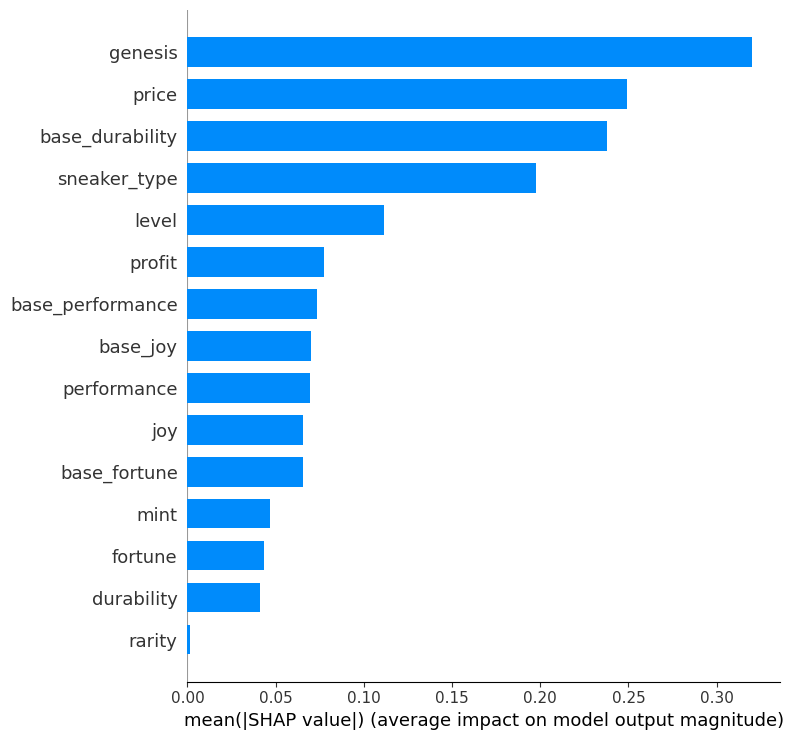

In [139]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## TEST

In [141]:
model = CatBoostClassifier(
    random_seed=42,
    depth=4,
    )

# Fit model 
model.fit(X_train, y_train, cat_features=cat_features,)
#model.save_model(f'./models/sneaker_model_{VERSION}.model')

Learning rate set to 0.004846
0:	learn: 0.6919510	total: 984us	remaining: 984ms
1:	learn: 0.6908576	total: 1.97ms	remaining: 983ms
2:	learn: 0.6896438	total: 2.96ms	remaining: 982ms
3:	learn: 0.6889314	total: 3.85ms	remaining: 959ms
4:	learn: 0.6877035	total: 4.72ms	remaining: 939ms
5:	learn: 0.6863603	total: 5.61ms	remaining: 929ms
6:	learn: 0.6853629	total: 6.49ms	remaining: 920ms
7:	learn: 0.6845522	total: 7.31ms	remaining: 907ms
8:	learn: 0.6838072	total: 7.95ms	remaining: 876ms
9:	learn: 0.6832566	total: 8.52ms	remaining: 843ms
10:	learn: 0.6815955	total: 9.08ms	remaining: 816ms
11:	learn: 0.6808607	total: 9.62ms	remaining: 792ms
12:	learn: 0.6797608	total: 10.2ms	remaining: 774ms
13:	learn: 0.6792371	total: 10.8ms	remaining: 758ms
14:	learn: 0.6779548	total: 11.3ms	remaining: 743ms
15:	learn: 0.6765409	total: 11.8ms	remaining: 728ms
16:	learn: 0.6756233	total: 12.4ms	remaining: 717ms
17:	learn: 0.6744787	total: 12.9ms	remaining: 705ms
18:	learn: 0.6728241	total: 13.5ms	remaining:

In [142]:
pred = model.predict_proba(X_test)[:,0]
#pred = np.round(pred, 2)
score = score_classifier_simple(y_test, pred,)
score

{'roc_auc_score': 0.777,
 'av_precision_score': 0.927,
 'accuracy_score': 0.409,
 'precision_score': 1.0,
 'recall_score': 0.433,
 'f1_score': 0.316,
 'matthews_corrcoef': 0.243}

In [144]:
submission = pd.DataFrame()
submission['profit'] = test_data.profit.copy().reset_index(drop=True)
submission['time_sell'] = test_data.target.copy().reset_index(drop=True)
submission['pred'] = pred

In [154]:
len(submission)

22

In [145]:
submission.profit.sum()

2.3550000000000004

In [146]:
submission.time_sell.mean()

0.7272727272727273

In [153]:
submission[submission['pred'] > 0.3]

,profit,time_sell,pred
0,0.0780,0,0.440579
1,-0.0045,1,0.328921
5,0.1455,1,0.423279
6,0.0700,1,0.591891
9,0.5655,1,0.599897
10,0.1080,1,0.484658
11,0.1305,1,0.340622
12,0.1325,1,0.480965
13,0.1475,0,0.358526
14,-0.0625,0,0.338184


In [155]:
submission[submission['pred'] > 0.3].profit.sum()

1.8005000000000002

In [156]:
submission[submission['pred'] > 0.3].time_sell.mean()

0.7142857142857143

In [103]:
pred = model.predict_proba(X_test)[:,0]
#pred = np.round(pred, 2)
score = score_classifier_simple(y_test, pred,)
score

{'roc_auc_score': 0.75,
 'av_precision_score': 0.911,
 'accuracy_score': 0.455,
 'precision_score': 1.0,
 'recall_score': 0.5,
 'f1_score': 0.4,
 'matthews_corrcoef': 0.289}

In [104]:
pred = model.predict_proba(X_test)[:,0]
#pred = np.round(pred, 2)
score = score_classifier_simple(y_test, pred,)
score

{'roc_auc_score': 0.75,
 'av_precision_score': 0.911,
 'accuracy_score': 0.455,
 'precision_score': 1.0,
 'recall_score': 0.5,
 'f1_score': 0.4,
 'matthews_corrcoef': 0.289}

## Fit full Model

In [105]:
X = data[features].copy().reset_index(drop=True)
y = data.target.copy().reset_index(drop=True)

model = CatBoostClassifier(random_seed=42,)

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_sell_time_bin_24h_model_{VERSION}.model')

Learning rate set to 0.005103
0:	learn: 0.6921333	total: 1.45ms	remaining: 1.45s
1:	learn: 0.6905670	total: 2.72ms	remaining: 1.36s
2:	learn: 0.6897272	total: 3.48ms	remaining: 1.16s
3:	learn: 0.6886122	total: 4.71ms	remaining: 1.17s
4:	learn: 0.6872767	total: 5.79ms	remaining: 1.15s
5:	learn: 0.6860409	total: 6.89ms	remaining: 1.14s
6:	learn: 0.6852768	total: 7.54ms	remaining: 1.07s
7:	learn: 0.6843824	total: 8.25ms	remaining: 1.02s
8:	learn: 0.6831233	total: 9.01ms	remaining: 992ms
9:	learn: 0.6820275	total: 9.73ms	remaining: 963ms
10:	learn: 0.6806179	total: 10.5ms	remaining: 943ms
11:	learn: 0.6799212	total: 11.2ms	remaining: 922ms
12:	learn: 0.6790624	total: 12ms	remaining: 908ms
13:	learn: 0.6777410	total: 12.6ms	remaining: 891ms
14:	learn: 0.6764443	total: 13.3ms	remaining: 874ms
15:	learn: 0.6754688	total: 14.1ms	remaining: 864ms
16:	learn: 0.6741195	total: 14.8ms	remaining: 854ms
17:	learn: 0.6723941	total: 15.5ms	remaining: 844ms
18:	learn: 0.6720499	total: 15.8ms	remaining: 

### Test

In [106]:
i=150

In [107]:
sneaker_dict = {
    'rarity': data.iloc[i]['rarity'],
    'sneaker_type': data.iloc[i]['sneaker_type'],
    #'genesis': True,
    'genesis': data.iloc[i]['genesis'],
    'level': data.iloc[i]['level'],
    'base_performance': data.iloc[i]['base_performance'],
    'base_fortune': data.iloc[i]['base_fortune'],
    'base_joy': data.iloc[i]['base_joy'],
    'base_durability': data.iloc[i]['base_durability'],
    'performance': data.iloc[i]['performance'],
    'fortune': data.iloc[i]['fortune'],
    'joy': data.iloc[i]['joy'],
    'durability': data.iloc[i]['durability'],
    #'condition': 100,
    'mint': data.iloc[i]['mint'],
    'wallet_from_buy_count': data.iloc[i]['wallet_from_buy_count'],
    'wallet_from_all_count': data.iloc[i]['wallet_from_all_count'],
    'buy_count_12H': data.iloc[i]['buy_count_12H'],
    'buy_count_24H': data.iloc[i]['buy_count_24H'],
    'sell_count_24H': data.iloc[i]['sell_count_24H'],
    'cancel_count_24H': data.iloc[i]['cancel_count_24H'],
    'min_price_all_24H': data.iloc[i]['min_price_all_24H'],
    'min_price_by_rarity_genesis_type_level_mint_24H': data.iloc[i]['min_price_by_rarity_genesis_type_level_mint_24H'],
    'min_price_by_rarity_genesis_type_level_mint_48H': data.iloc[i]['min_price_by_rarity_genesis_type_level_mint_48H'],
    'min_price_by_rarity_genesis_type_24H': data.iloc[i]['min_price_by_rarity_genesis_type_24H'],
    'token_all_activity_3H': data.iloc[i]['token_all_activity_3H'],
    'token_sell_activity_6H': data.iloc[i]['token_sell_activity_6H'],
    'price': data.iloc[i]['price'],
    'sell_price': data.iloc[i]['sell_price'],
    'profit': data.iloc[i]['profit'],
}

sneaker_dict['sum_activity_24H'] = sneaker_dict['buy_count_24H'] + sneaker_dict['sell_count_24H'] + sneaker_dict['cancel_count_24H']
sneaker_dict['sells_activity_24H'] = sneaker_dict['sell_count_24H'] / sneaker_dict['buy_count_24H']

sneaker_dict

{'rarity': 'common',
 'sneaker_type': 'coacher',
 'genesis': False,
 'level': 0,
 'base_performance': 3.6,
 'base_fortune': 3.2,
 'base_joy': 5.2,
 'base_durability': 1.3,
 'performance': 3.6,
 'fortune': 3.2,
 'joy': 5.2,
 'durability': 1.3,
 'mint': 0,
 'wallet_from_buy_count': 2,
 'wallet_from_all_count': 7,
 'buy_count_12H': 157,
 'buy_count_24H': 272,
 'sell_count_24H': 617,
 'cancel_count_24H': 338,
 'min_price_all_24H': 0.69,
 'min_price_by_rarity_genesis_type_level_mint_24H': 0.85,
 'min_price_by_rarity_genesis_type_level_mint_48H': 0.82,
 'min_price_by_rarity_genesis_type_24H': 0.75,
 'token_all_activity_3H': 1,
 'token_sell_activity_6H': 1,
 'price': 0.81,
 'sell_price': 1.29,
 'profit': 0.4155,
 'sum_activity_24H': 1227,
 'sells_activity_24H': 2.2683823529411766}

In [108]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] not in dq[feature]:
        print(f'{feature} not in data_quality_expected_range_dict. get {sneaker_dict[feature]}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] < dq[feature][0]:
        print(f'{feature} less then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][0]}')

    if sneaker_dict[feature] > dq[feature][1]:
        print(f'{feature} more then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][1]}')

In [109]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_sell_time_bin_24h_model_{VERSION}.model'

model = CatBoostClassifier()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

sample = pd.Series(sneaker_dict)
predict = model.predict_proba(sample[model.feature_names_])[0]
predict = np.round(predict, 2)
predict

0.26

In [110]:
sample[model.feature_names_]

rarity               common
sneaker_type        coacher
genesis               False
level                     0
base_performance        3.6
base_durability         1.3
performance             3.6
durability              1.3
mint                      0
dtype: object

In [111]:
data.iloc[i]['sell_time']

0

In [112]:
predict = model.predict_proba(sample[model.feature_names_])[0]
predict = np.round(predict, 2)
predict

0.26

In [113]:
sample['profit'] = 0.05

In [114]:
predict = model.predict_proba(sample[model.feature_names_])[0]
predict = np.round(predict, 2)
predict

0.26

In [115]:
sample['profit'] = 0.9
predict = model.predict_proba(sample[model.feature_names_])[0]
predict = np.round(predict, 2)
predict

0.26

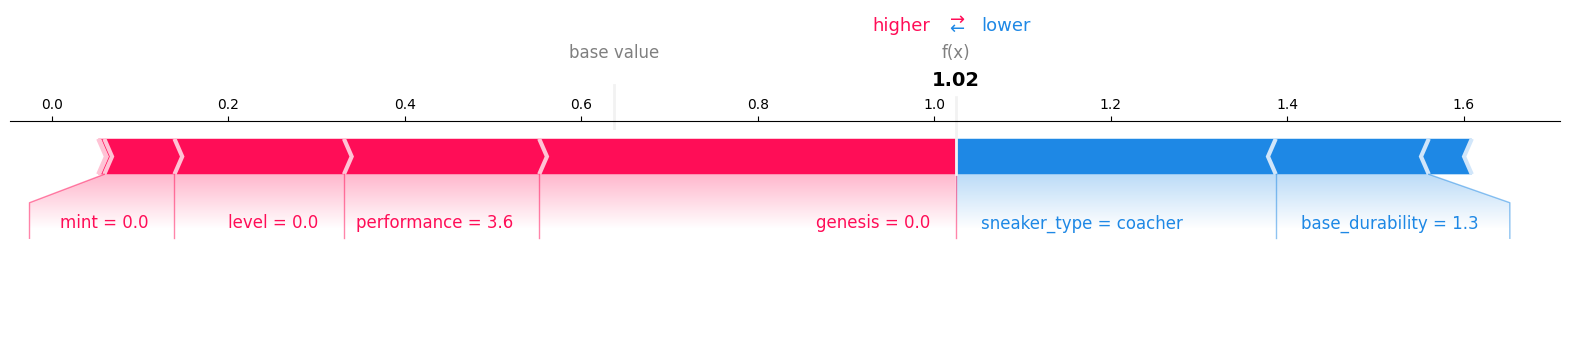

In [116]:
sample = pd.Series(sneaker_dict)
sample = pd.DataFrame(sample[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
#shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)